# 拒绝接受采样(Rejection Sampling)

### 拒绝接受采样 (Rejection Sampling)

拒绝采样是一种从目标分布中生成样本的技术，尤其在直接采样较为困难时显得尤为有用。

---

### 1. **基本原理**

拒绝接受采样的目标是从目标分布 $ p(x) $ 生成样本。通常 $ p(x) $ 可能比较复杂，直接采样不容易实现.

但我们可以找到一个易于采样的分布 $ q(x) $（称为提议分布，proposal distribution）和一个常数 $ M \geq 1 $

满足：

$$
p(x) \leq M q(x), \quad \forall x
$$

---

### 2. **算法步骤**

1. **选择提议分布 $ q(x) $**  
   确保 $ q(x) $ 易于采样，并且存在 $ M $ 使 $ p(x) \leq M q(x) $。

2. **采样与判断**  
   - 从 $ q(x) $ 中采样 $ x \sim q(x) $。
   - 生成一个均匀随机数 $ u \sim U(0, 1) $。
   - 接受样本 $ x $ 当且仅当：
     $$
     u \leq \frac{p(x)}{M q(x)}
     $$
   否则拒绝该样本，返回步骤 2 重新采样。

3. **重复**  
   直到生成足够多的样本。

---

### 3. **公式推导**

拒绝接受采样的核心在于接受概率的设计。假设我们采样得到的候选样本是 $ x \sim q(x) $，接受它的概率为：

$$
P_{\text{accept}} = \frac{p(x)}{M q(x)}
$$

整个采样过程生成的样本实际上遵循目标分布 $ p(x) $，证明如下：

#### 证明：
1. 候选样本的分布是 $ q(x) $。
2. 接受样本的概率是 $ \frac{p(x)}{M q(x)} $，因此生成的样本密度为：
   $$
   \text{Generated density} = q(x) \cdot \frac{p(x)}{M q(x)} = \frac{p(x)}{M}
   $$
3. 将所有可能的 $ x $ 加总，分布被重新归一化为：
   $$
   p_{\text{final}}(x) = \frac{\frac{p(x)}{M}}{\int \frac{p(x)}{M} dx} \\[4mm]
                       = \frac{\frac{1}{M} p(x)}{\frac{1}{M} \int p(x) dx} \\[4mm]
                       = p(x)
   $$

这证明了样本分布是 $ p(x) $。

---

### 4. **效率分析**

- **接受率**：
  $$
  \text{Acceptance Rate} = \frac{1}{M}
  $$
  $ M $ 越接近 1，拒绝接受采样越高效。因此，选择合适的 $ q(x) $ 和最小化 $ M $ 是提高效率的关键。

---

### 5. **优点与局限**

#### **优点**
- 简单易实现。
- 理论保证生成的样本符合目标分布。

#### **局限**
- 低效：如果 $ M $ 很大，大量样本会被拒绝。
- 需要 $ p(x) $ 和 $ q(x) $ 比较的上界 $ M $，在高维情况下选择 $ q(x) $ 较难。

---

## 代码：通过正态分布q(x)来采样chi-square分布p(x)

Text(0.5, 0, 'x')

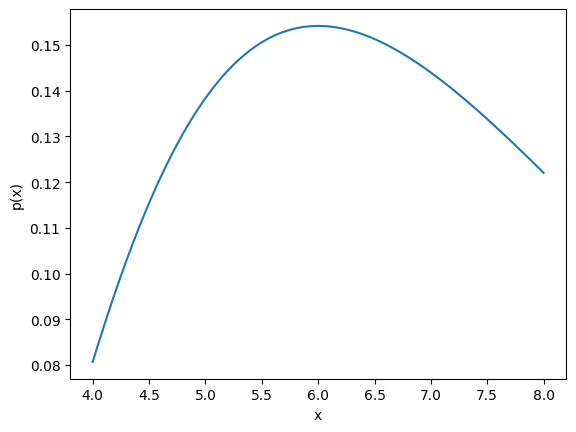

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as spstats

x = np.linspace(4, 8, 1000, endpoint=True) # 4到8左闭右闭，选1000个点
# px = spstats.norm(6, 3) # 均值为6，std为3
px = spstats.chi2(5,3)  #自由度为5 起始值为3的卡方分布

plt.plot(x, px.pdf(x))
plt.ylabel("p(x)")
plt.xlabel("x")

In [34]:
dx = x[1] - x[0]
np.sum(px.pdf(x) * dx)

0.547091248545982

Text(0.5, 0, 'x')

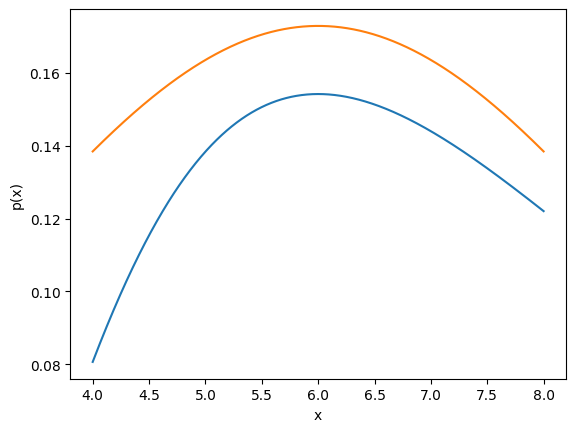

In [35]:
# 从图上可以看出，如果把M设置为1.3，那么就可以把目标分布包起来了
M = 1.3

# qx = spstats.uniform(4, 4) # 左端点为4，长度为4，也就是右端点为8的均匀分布
qx = spstats.norm(6, 3)

plt.plot(x, px.pdf(x))
plt.plot(x, M * qx.pdf(x))
plt.ylabel("p(x)")
plt.xlabel("x")

In [36]:
# 接受拒绝采样
def accept_reject():
    while True:
        while True:
            x = qx.rvs(1)[0] # 从qx中随机抽取一个采样点x
            if 4 <= x <= 8:  # 因为X的范围就是[4:8]左闭右闭
                break 
        u = np.random.uniform(0, 1)
        if px.pdf(x) >= u * M * qx.pdf(x):
            return x
        

# 采样
samples = [accept_reject() for _ in range(20_000)] # 抽取20_000个采样点

samples = np.array(samples)

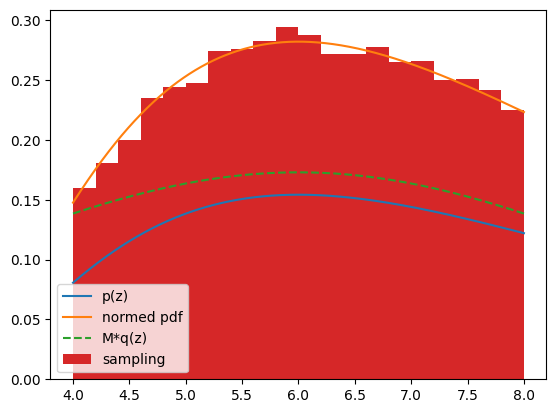

In [37]:
# 绘制采样结果，以及各种分布的对比
plt.plot(x, px.pdf(x), label='p(z)')
normed_value = px.cdf(8.0) - px.cdf(4.0) # 缩放系数就是[4:8]范围内，px的积分
plt.plot(x, px.pdf(x) / normed_value, label='normed pdf')  # 由于直方图是在[4:8]的区间上，积分为1。所以，我们得到的px的分布相当于做了缩放。

plt.plot(x, M * qx.pdf(x), '--', label='M*q(z)')
plt.hist(samples, bins=20, density=True, label='sampling') #通过 density=True 参数实现了直方图的归一化，使得直方图的面积为1

plt.legend()
plt.show()

In [38]:
# sample的分布和缩放后的px是一致的。
np.sum(px.pdf(x) * dx / normed_value)  # 可以发现，通过缩放，我们可以让px也在[4:8]的积分为1了

1.0007420394910627

## 使用拒绝采样来计算贝叶斯统计

$$
p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)}
$$

此时，我们可以选择目标分布为：

$$
\tilde p(\theta) = p(D | \theta)p(\theta)
$$

那么此时可以将提议分布设为:

$$
q(\theta) = p(\theta)
$$

那么常数M应该设置为多少呢？

我们来观察极大似然：
$$
\hat \theta = argmax( p(D | \theta) )
$$

因此：
$$
p(D | \hat \theta) \geqslant p(D | \theta)
$$

所以， 可以将M 设置为 $p(D | \hat \theta)$

因为：

$$
\frac{M q(\theta)}{\tilde p(\theta)} = \frac{p(D | \hat \theta) P(\theta)}{p(D | \theta) P(\theta)}
                                     = \frac{p(D | \hat \theta)}{p(D | \theta)}
                                     \geqslant 1
$$

至此，就知道如何用拒绝采样来计算贝叶斯统计量了。

## 拒绝采样方法与MCMC的区别

MCMC 通过一个马尔可夫链产生样本，而拒绝采样是一种直接生成符合目标分布的样本的方法。

MCMC不能并行的决定样本的去留，而决绝采样是可以的

---

### **MCMC 为什么比拒绝采样更灵活**
1. **提议分布的要求**：
   - 拒绝采样需要提议分布 $q(\theta)$ 满足 $p(\theta) \leq M q(\theta)$，这在高维问题中非常难找到合适的 $M$ 和 $q(\theta)$。
   - MCMC 不需要 $M$，只要提议分布 $q(\theta'|\theta)$ 足够灵活，能访问目标分布的所有区域即可。

2. **拒绝率**：
   - 拒绝采样的效率高度依赖于 $q(\theta)$ 和 $p(\theta)$ 的匹配程度。
   - MCMC 通过逐步更新样本，即使有部分提议被拒绝，也会逐渐接近目标分布。

3. **渐进性**：
   - 拒绝采样生成的每个样本是独立的，且立即符合目标分布。
   - MCMC 依赖马尔可夫链的稳态性质，随着采样步数增加，分布逐渐逼近目标分布。

---

### **总结：MCMC 与拒绝采样的关系**
1. **MCMC 利用拒绝采样的思想**：
   - 接受概率 $\alpha(\theta, \theta')$ 的设计灵感来自拒绝采样，通过调整提议分布的偏差来逼近目标分布。

2. **MCMC 的优势**：
   - MCMC 克服了拒绝采样在高维空间中的瓶颈问题，通过引入马尔可夫链的局部更新减少了对全局提议分布的依赖。

3. **共同点与区别**：
      
   **样本独立性**  
      - **拒绝采样**：每个样本独立地从目标分布中生成。  
      - **MCMC**：样本之间存在相关性（由马尔可夫链的性质决定），但随着采样进行，样本渐进逼近目标分布。  

   **依赖提议分布**  
      - **拒绝采样**：高度依赖提议分布 $ q(\theta) $ 与目标分布 $ p(\theta) $ 的匹配程度。  
      - **MCMC**：只需提议分布 $ q(\theta'|\theta) $ 有足够的覆盖性，匹配要求较低。  

   **高维适用性**  
      - **拒绝采样**：在高维情况下，很难找到合适的提议分布 $ q(\theta) $ 和缩放因子 $ M $。  
      - **MCMC**：更适合高维空间，因为通过局部步进探索目标分布，而不依赖全局覆盖。  

   **接受概率的思想**  
      - **拒绝采样**：候选样本的接受概率为：  
      $$
      P_\text{accept} = \frac{p(\theta)}{M \cdot q(\theta)},
      $$  
      其中 $ M $ 是保证 $ p(\theta) \leq M \cdot q(\theta) $ 的常数。  

      - **MCMC（以 Metropolis-Hastings 为例）**：候选样本 $\theta'$ 的接受概率为：  
      $$
      P_\text{accept} = \min\left(1, \frac{p(\theta') \cdot q(\theta|\theta')}{p(\theta) \cdot q(\theta'|\theta)}\right),
      $$  
      其中 $ q(\theta'|\theta) $ 是从当前状态 $\theta$ 提议到新状态 $\theta'$ 的概率。  